In [1]:
import rsatoolbox as rsa
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

# Add the parent directory to sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_path not in sys.path:
    sys.path.append(project_path)

import globals as gl



Base directory found: /Volumes/diedrichsen_data$/data/Chord_exp/ExtFlexChord


plotting...glm1.L.SMA.hdf5


AttributeError: rdm_descriptors have mismatched dimension with measurements.

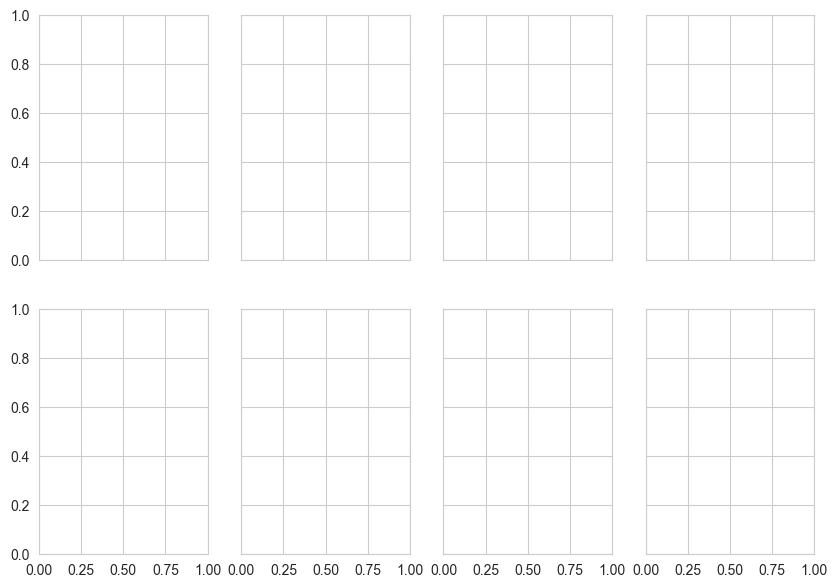

In [3]:
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']

experiment = 'efc4'

Hem = 'L'
r = 0
glm = 1
vmin, vmax = -1, 1
participant_id='subj100'
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10, 7))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        print(f'plotting...glm{glm}.{Hem}.{roi[r]}.hdf5')
        rdms = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1',participant_id,f'glm{glm}.{Hem}.{roi[r]}.hdf5'))

        cax = rsa.vis.show_rdm_panel(
                rdms, axs[i, j], rdm_descriptor='roi', cmap='viridis', #vmin=vmin, vmax=vmax
            )
        axs[i, j].set_xticks(np.arange(len(rdms.pattern_descriptors['conds'])))
        axs[i, j].set_xticklabels(rdms.pattern_descriptors['conds'], rotation=45, ha='right')
        axs[i, j].set_yticks(axs[i, j].get_xticks())
        axs[i, j].set_yticklabels(rdms.pattern_descriptors['conds'])
        axs[i, j].set_title(roi[r])

        # axs[i, j].axhline(0, color='k', ls='-', lw=.8)
        # axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        r += 1

cbar = fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=.02)
cbar.set_label('Cross-validated multivariate distance (a.u.)')
fig.suptitle(f'participant:{participant_id}, hemisphere:{Hem}')